In [10]:
# Load libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

## Download Data

##### Download stock price data from Yahoo Finance using python yfinance library.

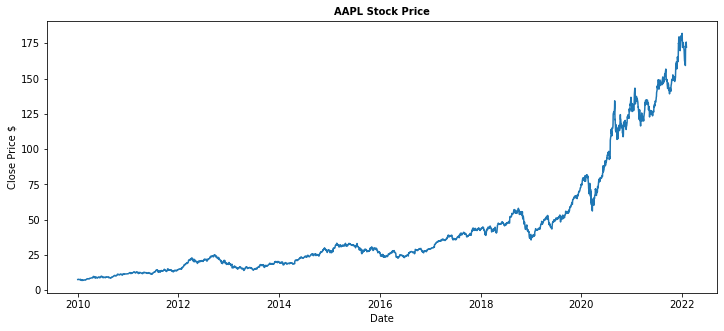

In [11]:
def download_data(company, start_date, end_date):
    # get the data from Yahoo Finance
    data = yf.download(company, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
    
    plt.figure(figsize=(12,5))
    plt.plot(data['Close'])
    plt.title(f"{company} Stock Price",fontsize=10, fontweight='bold')
    plt.xlabel('Date',fontsize=10)
    plt.ylabel('Close Price $',fontsize=10)
    plt.show()
    return data

df = download_data('AAPL','2010-01-01', '2022-02-06')

## Data preparation: modify data and remove other columns

In [12]:
def modify_data(data):
    # modify data and remove other columns 
    # 0: stock price decreasing
    # 1: stock price increasing
    data_np = np.array(data['Close'])
    up_down = np.zeros(data_np.size)
    for i in range(1,data_np.size):
        if(data_np[i]-data_np[i-1] > 0):
            up_down[i] = 1
        else:
            up_down[i] = 0
    data['up_down'] = up_down
    data.drop(data.columns.difference(['Date','up_down']), 1, inplace=True)
    return data
df = modify_data(df)
df

,up_down
Date,
2009-12-31,0.0
2010-01-04,1.0
2010-01-05,1.0
2010-01-06,0.0
2010-01-07,0.0
...,...
2022-01-31,1.0
2022-02-01,0.0
2022-02-02,1.0


## Generating training and test datasets

In [13]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    # create all possible sequences of length lookback
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

# Choose sequence length
lookback = 40 
x_train, y_train, x_test, y_test = split_data(df, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2405, 39, 1)
y_train.shape =  (2405, 1)
x_test.shape =  (601, 39, 1)
y_test.shape =  (601, 1)


## Defining Dataloader

In [14]:
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(x_train, y_train.squeeze())
dataset_test = TimeSeriesDataset(x_test, y_test.squeeze())

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (2405, 39, 1) (2405,)
Test data shape (601, 39, 1) (601,)


## Defining the GRU model

In [15]:
# parameters
input_dim = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
num_epochs = 70
batch_size = 64
learning_rate = 0.01
scheduler_step_size = 50

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(hidden_layer_size, hidden_layer_size, num_layers, batch_first=True)
        self.fc = nn.Linear(num_layers*hidden_layer_size, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        for name, param in self.gru.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]
        
        # layer 1 
        x = self.linear_1(x)
        x = self.relu(x)
        
        # GRU layer
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).requires_grad_()
        gru_out, h_n = self.gru(x , h0.detach())
        
        # reshape output from hidden cell into [batch, features] for `linear_2
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        
        # layer 2
        x = self.dropout(x)
        predictions = self.fc(x) 
        
        # Sigmoid layer
        return self.activation(predictions[:,-1])

model = GRUModel(input_size=input_dim, hidden_layer_size=hidden_dim, num_layers=num_layers, output_size=output_dim, dropout=0.3)
model = model.to('cpu')

## Train the model

In [16]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()
        
        batchsize = x.shape[1]
        
        # to device
        x = x.to("cpu")
        y = y.to("cpu")
        
        # predict
        out = model(x)
        
        # loss calculation
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)
        
        # scheduler
        lr = scheduler.get_last_lr()[0]
        
    return epoch_loss,lr

# create DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=0.1)

# for loss plotting 
hist_train = np.zeros(num_epochs)
hist_test = np.zeros(num_epochs)

# begin training
for epoch in range(num_epochs):
    loss_train, lr = run_epoch(train_dataloader, is_training=True)
    loss_test, lr = run_epoch(test_dataloader)
    scheduler.step()
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} ,lr :{:.5f}   '
              .format(epoch+1, num_epochs, loss_train, loss_test, lr))
    hist_train[epoch] = loss_train
    hist_test[epoch] = loss_test

Epoch[1/70] | loss train:0.716441, test:0.176636 ,lr :0.01000   
Epoch[2/70] | loss train:0.688881, test:0.177491 ,lr :0.01000   
Epoch[3/70] | loss train:0.685638, test:0.177140 ,lr :0.01000   
Epoch[4/70] | loss train:0.684594, test:0.178082 ,lr :0.01000   
Epoch[5/70] | loss train:0.685457, test:0.177479 ,lr :0.01000   
Epoch[6/70] | loss train:0.684357, test:0.177535 ,lr :0.01000   
Epoch[7/70] | loss train:0.694071, test:0.177354 ,lr :0.01000   
Epoch[8/70] | loss train:0.683412, test:0.177209 ,lr :0.01000   
Epoch[9/70] | loss train:0.698357, test:0.179022 ,lr :0.01000   
Epoch[10/70] | loss train:0.689256, test:0.177264 ,lr :0.01000   
Epoch[11/70] | loss train:0.687396, test:0.186611 ,lr :0.01000   
Epoch[12/70] | loss train:0.697542, test:0.183758 ,lr :0.01000   
Epoch[13/70] | loss train:0.695794, test:0.177293 ,lr :0.01000   
Epoch[14/70] | loss train:0.682232, test:0.177520 ,lr :0.01000   
Epoch[15/70] | loss train:0.699887, test:0.178651 ,lr :0.01000   
Epoch[16/70] | loss

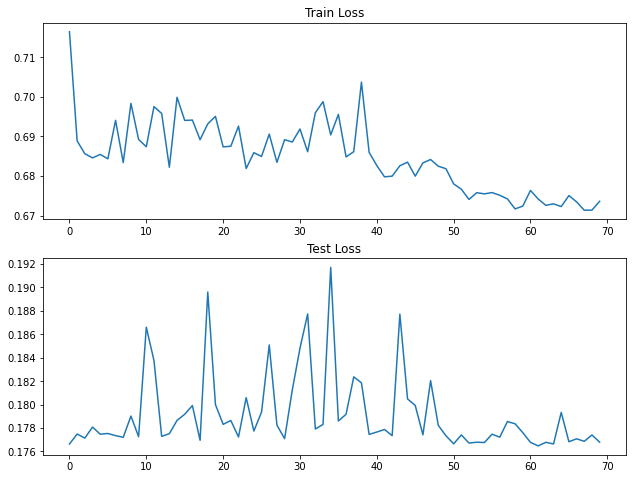

In [17]:
def loss_plot(hist_train,hist_test):
    fig, (ax1, ax2) = plt.subplots(2,figsize=(12,3))
    plt.subplots_adjust(bottom=0.1, right=0.8, top=2.1)
    ax1.title.set_text('Train Loss')
    ax2.title.set_text('Test Loss')
    ax1.plot(hist_train)
    ax2.plot(hist_test)
    plt.show
    
loss_plot(hist_train,hist_test)

## Calculate the Accuracy, Precision, Recall and F1 score

In [18]:
from sklearn.metrics import f1_score,recall_score,precision_score 

# here we re-initialize dataloader so the data doesn't shuffled, so we can calcluate the accuracy

train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=32, shuffle=False)

model.eval()

# predict on the train data

predicted_train = np.array([])
train_y = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to('cpu')
    out = model(x)
    out = out.cpu().detach().numpy()

    predicted_train = np.concatenate((predicted_train, out))
    train_y = np.concatenate((train_y,y))

# predict on the test data
predicted_test = np.array([])
test_y = np.array([])

for idx, (x, y) in enumerate(test_dataloader):
    x = x.to('cpu')
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_test = np.concatenate((predicted_test, out))
    test_y = np.concatenate((test_y,y))

# train accuracy calculation
train_acc = torch.sum(torch.round(torch.tensor(predicted_train)) == torch.tensor(train_y))
final_train_acc = train_acc/predicted_train.shape[0]

# test accuracy calculation
test_acc = torch.sum(torch.round(torch.tensor(predicted_test)) == torch.tensor(test_y))
final_test_acc = test_acc/predicted_test.shape[0]

# Precision, Recall and F1 score
recall = recall_score(train_y, torch.round(torch.tensor(predicted_train)))
precision = precision_score(train_y, torch.round(torch.tensor(predicted_train)))
f1 = f1_score(train_y, torch.round(torch.tensor(predicted_train)))

print("Train accuracy = {:.2f}".format(final_train_acc.item()))
print("Test accuracy = {:.2f}".format(final_test_acc.item()))
print("Recall = {:.2f}".format(recall))
print("Precision = {:.2f}".format(precision))
print("F1 = {:.2f}".format(f1))

Train accuracy = 0.54
Test accuracy = 0.53
Recall = 0.80
Precision = 0.55
F1 = 0.65


## Save the model

In [167]:
torch.save(model, "stock_price_gru.pth")

In [6]:
!pip install pipreqs

In [9]:
!pipreqs --force

INFO: Successfully saved requirements file in /home/codics/DataspellProjects/Stockupdown/requirements.txt
